# 🔥 PyTorch Tabular Data Classification ©

## 🌾 Rice Classification Model

Classifies rice grains into two types based on physical measurements.

Input:

    10 physical features (Area, MajorAxisLength, MinorAxisLength,   Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation)

Output:

    Class 1 = Jasmine

    Class 0 = Gonen

Use case: Automated rice quality checking and sorting.

In [2]:
!pip install opendatasets --quiet

import opendatasets as od

# download rice type classification dataset from Kaggle
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mdsafwanbinrashid
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 865MB/s]

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
data_df.drop(['id'], axis=1, inplace=True)
print(data_df.shape)

(18185, 11)


In [6]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
data_df["Class"].unique() # types of target: 0 or 1

array([1, 0])

In [8]:
data_df["Class"].value_counts()

,count
Class,
1,9985
0,8200


In [9]:
# normalization: scales each value to range [-1, 1]
original_df = data_df.copy()

for c in data_df.columns:
  data_df[c] = data_df[c] / data_df[c].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [10]:
# train-validation-test split
X = np.array(data_df.iloc[:,:-1]) # all rows + (all columns except the last one)
Y = np.array(data_df.iloc[:,-1])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


PyTorch needs to know:

1. How to get each sample(`__getitem__`)
2. How many samples exist (`__len__`)
3. What format the data is in (tensors, on device)

Without this, PyTorch wouldn't know how to access the data for training.

Also, DataLoader uses Dataset class to automatically handle batching, shuffling, and parallel loading during training.

In [11]:
# custom PyTorch Dataset class
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device) # convert features (X) to tensor
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device) # convert labels (Y) to tensor

    def __len__(self):
        return len(self.X)  # returns num of samples

    def __getitem__(self, index):
        return self.X[index], self.Y[index]  # returns one sample (X, Y)

In [12]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

DataLoader is a PyTorch utility that efficiently loads data in batches during model training.

In [13]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)

**Neural Network Model**

    super - calls the constructor

    def init hold the layers to be used in forward pass

    sigmoid converts any number to a value between 0 and 1, making it perfect for binary classification

    using X.shape[1] makes the code dynamic and reusable - it automatically adapts to any dataset without manual changes

In [14]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)  # input to hidden
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)  # hidden to output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [15]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [16]:
# training while tracking losses
train_losses = []
val_losses = []

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    # training
    model.train()
    train_loss = 0

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        predictions = model(inputs).view(-1)
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            predictions = model(inputs).view(-1)
            labels = labels.view(-1)
            loss = criterion(predictions, labels)
            val_loss += loss.item()

    # calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch 1: Train Loss: 0.3925, Val Loss: 0.1349
Epoch 2: Train Loss: 0.0844, Val Loss: 0.0631
Epoch 3: Train Loss: 0.0525, Val Loss: 0.0516
Epoch 4: Train Loss: 0.0451, Val Loss: 0.0472
Epoch 5: Train Loss: 0.0425, Val Loss: 0.0469
Epoch 6: Train Loss: 0.0415, Val Loss: 0.0464
Epoch 7: Train Loss: 0.0407, Val Loss: 0.0454
Epoch 8: Train Loss: 0.0410, Val Loss: 0.0453
Epoch 9: Train Loss: 0.0402, Val Loss: 0.0455
Epoch 10: Train Loss: 0.0405, Val Loss: 0.0454


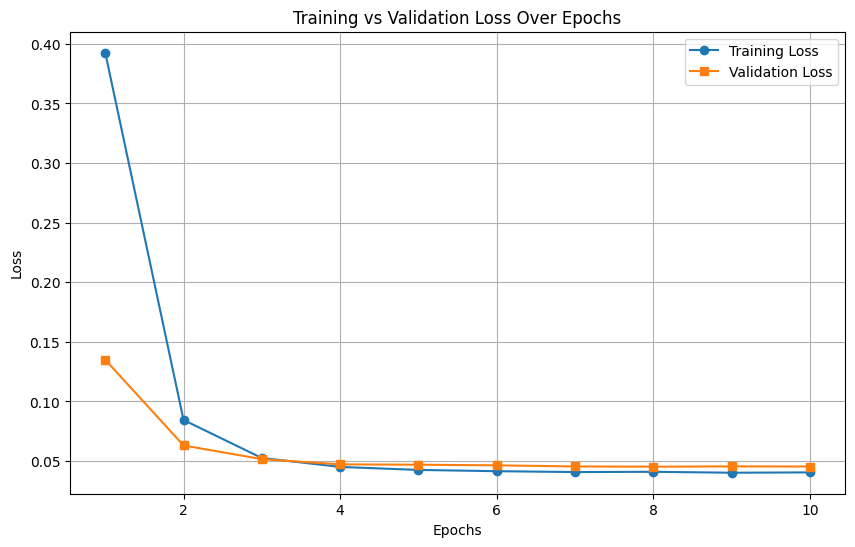

In [19]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# overfitting - if validation loss starts increasing while training loss decreases

In [30]:
print("🌾 Enter rice features for prediction:")

area = float(input("Area: "))
major_axis = float(input("MajorAxisLength: "))
minor_axis = float(input("MinorAxisLength: "))
eccentricity = float(input("Eccentricity: "))
convex_area = float(input("ConvexArea: "))
equiv_diameter = float(input("EquivDiameter: "))
extent = float(input("Extent: "))
perimeter = float(input("Perimeter: "))
roundness = float(input("Roundness: "))
aspect_ratio = float(input("AspectRation: "))

# normalization (divide by max values)
features = [
    area / 10000,
    major_axis / 200,
    minor_axis / 100,
    eccentricity,           # already normalized (0-1)
    convex_area / 10000,
    equiv_diameter / 150,
    extent,                 # already normalized (0-1)
    perimeter / 500,
    roundness,              # already normalized (0-1)
    aspect_ratio            # already normalized (0-1)
]

# make prediction
model.eval()
with torch.no_grad():
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    features_tensor = features_tensor.unsqueeze(0)

    prediction = model(features_tensor)
    probability = prediction.item()
    predicted_class = 1 if probability > 0.5 else 0

print(f"\n Prediction: Class {predicted_class} ({'Jasmine' if predicted_class == 1 else 'Gonen'})")
print(f" Confidence: {probability:.3f}")

🌾 Enter rice features for prediction:
Area: 0.66
MajorAxisLength: 0.32
MinorAxisLength: 0.5
Eccentricity: 0.68
ConvexArea: 0.23
EquivDiameter: 0.5
Extent: 0.51
Perimeter: 0.8
Roundness: 0.7
AspectRation: 0.9

 Prediction: Class 1 (Jasmine)
 Confidence: 1.000
